# Генерация заголовков научных статей: слабый baseline

Источник: https://github.com/bentrevett/pytorch-seq2seq

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_en = spacy.load('en')

In [4]:
def tokenize(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text) if not tok.text.isspace()]

In [5]:
from torchtext import data, vocab

tokenizer = data.get_tokenizer('spacy')
TEXT = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            include_lengths = True,
            lower = True)



In [6]:
# let's train model on a part of train.csv to speed up computations

# import pandas as pd

# train_df = pd.read_csv('/kaggle/input/title-generation/train.csv').head(30001)
# train_df.to_csv('/kaggle/working/train_small.csv', index=False)

In [7]:
%%time
trn_data_fields = [("src", TEXT),
                   ("trg", TEXT)]

dataset = data.TabularDataset(
    path='/kaggle/input/title-generation/train.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

CPU times: user 7min 21s, sys: 2.18 s, total: 7min 23s
Wall time: 7min 25s


In [8]:
TEXT.build_vocab(train_data, min_freq = 7)
print(f"Unique tokens in vocabulary: {len(TEXT.vocab)}")

Unique tokens in vocabulary: 40492


In [9]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            # and mask
            #receive output tensor (predictions), new hidden state and attention tensor
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #place attentions in a tensor holding attention value for each input token
            attentions[t] = attention
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
            #if doing inference and next token/prediction is an eos token then stop
            if inference and input.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

In [14]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi['<pad>']
SOS_IDX = TEXT.vocab.stoi['<sos>']
EOS_IDX = TEXT.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

In [15]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(40492, 128)
    (rnn): GRU(128, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=64, bias=True)
    )
    (embedding): Embedding(40492, 128)
    (rnn): GRU(256, 64)
    (out): Linear(in_features=320, out_features=40492, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,520,876 trainable parameters


In [17]:
optimizer = optim.Adam(model.parameters())

In [18]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

### Обучение модели

In [19]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg, trg_len = batch.trg
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg, trg_len = batch.trg

            output, attention = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
MODEL_NAME = '/kaggle/working/baseline2.pt'

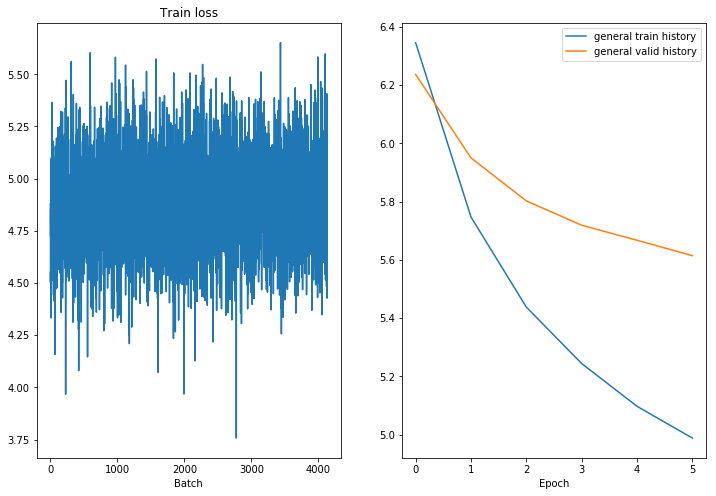

Epoch: 07 | Time: 18m 48s
	Train Loss: 4.896 | Train PPL: 133.690
	 Val. Loss: 5.588 |  Val. PPL: 267.177


In [23]:
# to get results like in leaderboard train the model
# for 10 epochs on the whole dataset (135000 samples instead of 30000)

N_EPOCHS = 7
CLIP = 1

train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [24]:
# for cpu usage
# model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')))

# for gpu usage
# model.load_state_dict(torch.load(MODEL_NAME), map_location=torch.device('cpu'))


test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.609 | Test PPL: 272.976 |


### Генерация заголовков

In [25]:
def translate_sentence(model, tokenized_sentence):
    model.eval()
    tokenized_sentence = ['<sos>'] + [t.lower() for t in tokenized_sentence] + ['<eos>']
    numericalized = [TEXT.vocab.stoi[t] for t in tokenized_sentence] 
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TEXT.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

In [26]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(30,50))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy().T
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=12)
    ax.set_yticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'])
    ax.set_xticklabels(['']+translation, rotation=80)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [27]:
example_idx = 100

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['the', 'integrated', 'completed', 'likelihood', '(', 'icl', ')', 'criterion', 'has', 'proven', 'to', 'be', 'a', 'very', 'popular', 'approach', 'in', 'model', '-', 'based', 'clustering', 'through', 'automatically', 'choosing', 'the', 'number', 'of', 'clusters', 'in', 'a', 'mixture', 'model', '.', 'this', 'approach', 'effectively', 'maximises', 'the', 'complete', 'data', 'likelihood', ',', 'thereby', 'including', 'the', 'allocation', 'of', 'observations', 'to', 'clusters', 'in', 'the', 'model', 'selection', 'criterion', '.', 'however', 'for', 'practical', 'implementation', 'one', 'needs', 'to', 'introduce', 'an', 'approximation', 'in', 'order', 'to', 'estimate', 'the', 'icl', '.', 'our', 'contribution', 'here', 'is', 'to', 'illustrate', 'that', 'through', 'the', 'use', 'of', 'conjugate', 'priors', 'one', 'can', 'derive', 'an', 'exact', 'expression', 'for', 'icl', 'and', 'so', 'avoiding', 'any', 'approximation', '.', 'moreover', ',', 'we', 'illustrate', 'how', 'one', 'can', 'find',

In [28]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'bayesian', 'model', 'for', 'model', 'selection']


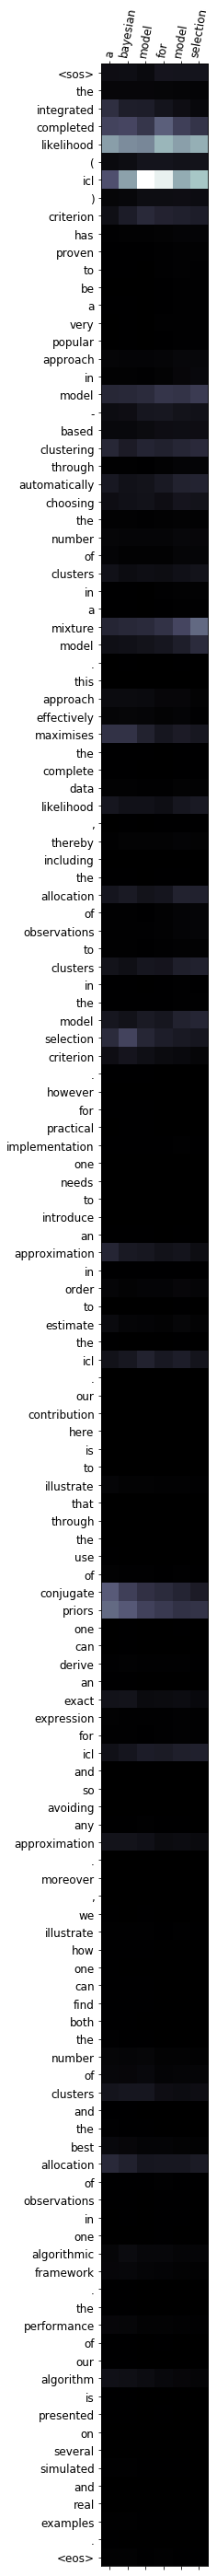

In [29]:
display_attention(src, translation, attention)

In [30]:
for example_idx in range(100):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(model, src)

    print('Оригинальный заголовок: ', ' '.join(trg))
    print('Предсказанный заголовок: ', ' '.join(translation))
    print('-----------------------------------')

Оригинальный заголовок:  diversity and its decomposition into variety , balance and disparity
Предсказанный заголовок:  a the of of : a new approach to the
-----------------------------------
Оригинальный заголовок:  improving the johnson - lindenstrauss lemma
Предсказанный заголовок:  on the of of of
-----------------------------------
Оригинальный заголовок:  the mean - field approximation model of company 's income growth
Предсказанный заголовок:  a - of income income
-----------------------------------
Оригинальный заголовок:  efficient inference of protein structural ensembles
Предсказанный заголовок:  a coarse - grained models models
-----------------------------------
Оригинальный заголовок:  financial black swans driven by ultrafast machine ecology
Предсказанный заголовок:  the - of the - - : a - - and the -
-----------------------------------
Оригинальный заголовок:  tracking dynamic point processes on networks
Предсказанный заголовок:  online learning networks for social netw

In [31]:
example_idx = 0

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['suppose', 'a', 'string', '$', 'x_1^n=(x_1,x_2,', '...', ',x_n)$', 'generated', 'by', 'a', 'memoryless', 'source', '$', '(', 'x_n)_{n\\geq', '1}$', 'with', 'distribution', '$', 'p$', 'is', 'to', 'be', 'compressed', 'with', 'distortion', 'no', 'greater', 'than', '$', 'd\\geq', '0', '$', ',', 'using', 'a', 'memoryless', 'random', 'codebook', 'with', 'distribution', '$', 'q$.', 'the', 'compression', 'performance', 'is', 'determined', 'by', 'the', '`', '`', 'generalized', 'asymptotic', 'equipartition', 'property', "'", "'", '(', 'aep', ')', ',', 'which', 'states', 'that', 'the', 'probability', 'of', 'finding', 'a', '$', 'd$-close', 'match', 'between', '$', 'x_1^n$', 'and', 'any', 'given', 'codeword', '$', 'y_1^n$', ',', 'is', 'approximately', '$', '2^{-n', 'r(p', ',', 'q', ',', 'd)}$', ',', 'where', 'the', 'rate', 'function', '$', 'r(p', ',', 'q', ',', 'd)$', 'can', 'be', 'expressed', 'as', 'an', 'infimum', 'of', 'relative', 'entropies', '.', 'the', 'main', 'purpose', 'here', 'is', 

predicted trg = ['on', 'the', 'of', 'of', 'of', 'of']


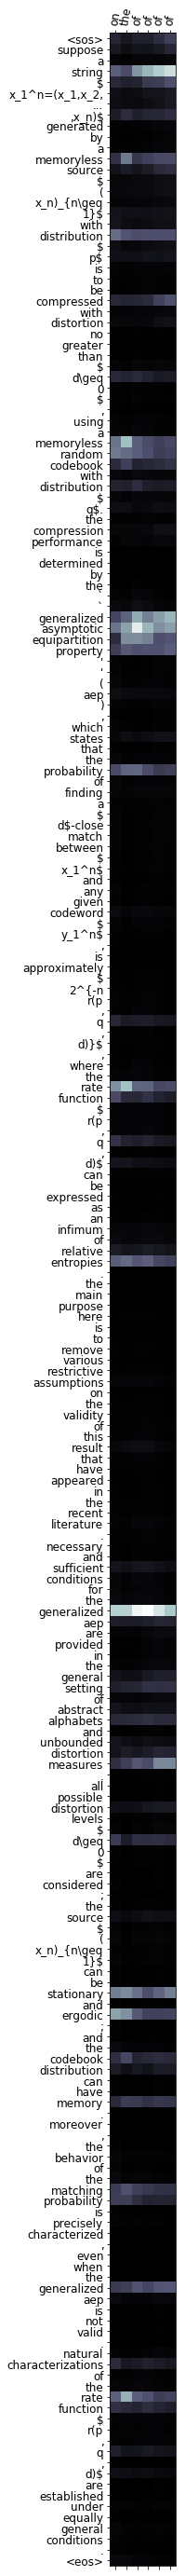

In [32]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [33]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['we', 'undertake', 'a', 'systematic', 'comparison', 'between', 'implied', 'volatility', ',', 'as', 'represented', 'by', 'vix', '(', 'new', 'methodology', ')', 'and', 'vxo', '(', 'old', 'methodology', ')', ',', 'and', 'realized', 'volatility', '.', 'we', 'compare', 'visually', 'and', 'statistically', 'distributions', 'of', 'realized', 'and', 'implied', 'variance', '(', 'volatility', 'squared', ')', 'and', 'study', 'the', 'distribution', 'of', 'their', 'ratio', '.', 'we', 'find', 'that', 'the', 'ratio', 'is', 'best', 'fitted', 'by', 'heavy', '-', 'tailed', '--', 'lognormal', 'and', 'fat', '-', 'tailed', '(', 'power', '-', 'law', ')', '--', 'distributions', ',', 'depending', 'on', 'whether', 'preceding', 'or', 'concurrent', 'month', 'of', 'realized', 'variance', 'is', 'used', '.', 'we', 'do', 'not', 'find', 'substantial', 'difference', 'in', 'accuracy', 'between', 'vix', 'and', 'vxo', '.', 'additionally', ',', 'we', 'study', 'the', 'variance', 'of', 'theoretical', 'realized', 'vari

predicted trg = ['the', 'volatility', 'of', 'the', 'volatility', 'volatility']


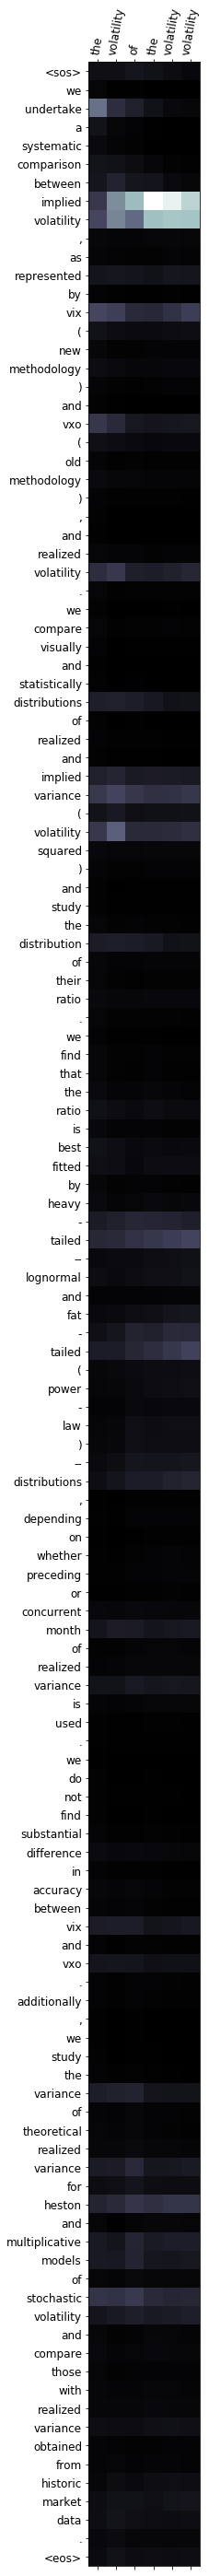

In [34]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### Считаем BLEU

In [35]:
import nltk

n_gram_weights = [0.3334, 0.3333, 0.3333]

In [36]:
test_len = len(test_data)

In [37]:
original_texts = []
generated_texts = []
macro_bleu = 0

for example_idx in range(test_len):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, _ = translate_sentence(model, src)

    original_texts.append(trg)
    generated_texts.append(translation)

    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        [trg],
        translation,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score

macro_bleu /= test_len

/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [38]:
# averaging sentence-level BLEU (i.e. macro-average precision)
print('Macro-average BLEU (LSTM): {0:.5f}'.format(macro_bleu))

Macro-average BLEU (LSTM): 0.28204


### Делаем submission в Kaggle

In [39]:
import pandas as pd

submission_data = pd.read_csv('/kaggle/input/title-generation/test.csv')
abstracts = submission_data['abstract'].values

Генерация заголовков для тестовых данных:

In [40]:
titles = []
for abstract in abstracts:
    title, _ = translate_sentence(model, abstract.split())
    titles.append(' '.join(title).replace('<unk>', ''))

Записываем полученные заголовки в файл формата `<abstract>,<title>`:

In [41]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

С помощью функции `generate_csv` приводим файл `submission_prediction.csv` в формат, необходимый для посылки в соревнование на Kaggle:

In [42]:
import string
from nltk.util import ngrams
import numpy as np
import pandas as pd
import pickle


def generate_csv(input_file='predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file='/kaggle/input/title-generation/vocs.pkl'):
    '''
    Generates file in format required for submitting result to Kaggle
    
    Parameters:
        input_file (str) : path to csv file with your predicted titles.
                           Should have two fields: abstract and title
        output_file (str) : path to output submission file
        voc_file (str) : path to voc.pkl file
    '''
    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])
        
        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))    

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1


generate_csv()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: generator 'ngrams' raised StopIteration
